Gender Prediction Using CNN

# Importing the dataset first through kaggle api

In [ ]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json 

In [ ]:
!kaggle datasets download -d ashishjangra27/gender-recognition-200k-images-celeba

 99% 1.31G/1.32G [00:14<00:00, 140MB/s]
100% 1.32G/1.32G [00:14<00:00, 95.7MB/s]


In [ ]:
from zipfile import ZipFile
dataset = '/content/gender-recognition-200k-images-celeba.zip'
with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print("Done.")

Done.


# Import the necessaary Module

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import PIL
import os
from tqdm.notebook import tqdm
import uuid
import cv2

get the dataset from the folder

In [ ]:
train = []
test = []
base_path = '/content/Dataset/Train'
for folder in ['Female','Male']:
    curpath = os.path.join(base_path , folder)
    cnt = 0
    for file in os.listdir(curpath):
        if (cnt==10000): break
        train.append(os.path.join(curpath,file))
        if folder=='Female':
            test.append(1)
        else:
            test.append(0)
        cnt+=1

In [ ]:
# Printing the size of train and test
print("Size of Train : " , len(train) )
print("Size of Test : " , len(test) )

Size of Train :  20000
Size of Test :  20000


Visualize the image with their gender

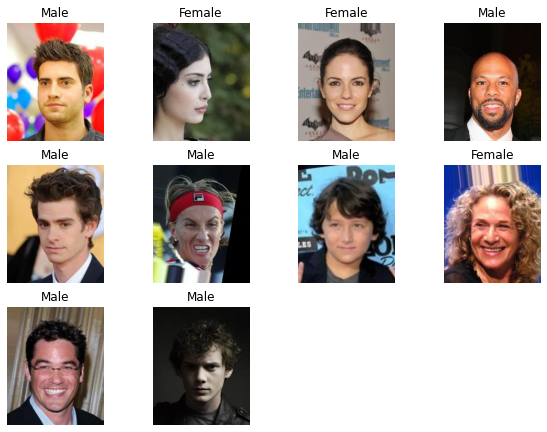

In [ ]:
import random
plt.figure(figsize=(10,10))
for i in range(10):
  plt.subplot(4,4,i+1)
  idx = random.randint(0,20000)
  img = keras.preprocessing.image.load_img(train[idx])
  plt.imshow(img)
  plt.axis("off")
  title_data = "Male" if test[idx]==0 else "Female"
  plt.title(title_data)


In [ ]:
# Making a function to convert image into numpy array

def path_to_array():
  images_data = []
  for img_path in tqdm(train):
    img = keras.preprocessing.image.load_img(img_path,grayscale=True)
    img_resize = img.resize((128,128) , PIL.Image.ANTIALIAS)
    img_resize = np.array(img_resize)
    images_data.append(img_resize)
  
  images_data = np.array(images_data)
  images_data = images_data.reshape(len(images_data), 128,128,1)
  return images_data

In [ ]:
train_data = path_to_array()

  0%|          | 0/20000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [ ]:
train_data.shape

(20000, 128, 128, 1)

In [ ]:
# making data standardize
train_data = train_data/255.0

In [ ]:
train_data.shape

(20000, 128, 128, 1)

In [ ]:
test = np.array(test)

In [ ]:
test.shape

(20000,)

# Spliting the data into training and testing

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test , Y_train, Y_test = train_test_split(train_data,test, test_size = 0.2)

In [ ]:
X_train.shape

(16000, 128, 128, 1)

In [ ]:
X_test.shape

(4000, 128, 128, 1)

# Building the model

In [ ]:
input = keras.layers.Input(shape=(128,128,1))
conv1 = keras.layers.Conv2D(32, kernel_size=(5,5), activation = 'relu')(input)
pool1 = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(conv1)
conv2 = keras.layers.Conv2D(64,kernel_size=(3,3),activation = 'relu')(pool1)
pool2 = keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2))(conv2)
flatten = keras.layers.Flatten()(pool2)
dense1 = keras.layers.Dense(64,activation = 'relu')(flatten)
dense2 = keras.layers.Dense(128,activation = 'relu')(dense1)
output = keras.layers.Dense(1,activation = 'sigmoid')(dense2)

model = keras.models.Model(inputs = input , outputs = output)

In [ ]:
# Lets compile the model now.
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# Summary of model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0     

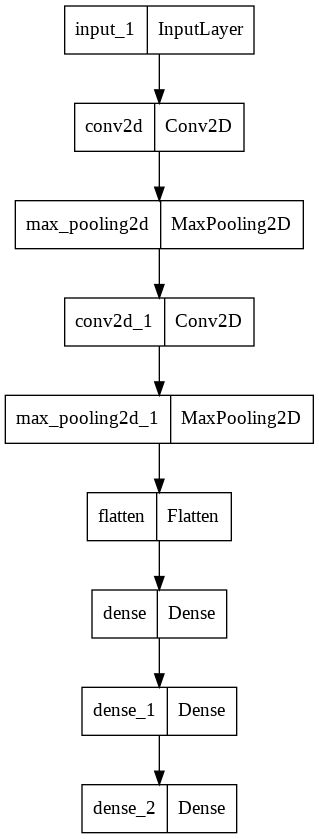

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

# Fitting into the Model

In [ ]:
fit_model = model.fit(X_train, Y_train,epochs = 2) 

Epoch 1/2
500/500 [==============================] - 331s 660ms/step - loss: 0.2975 - accuracy: 0.8692
Epoch 2/2
500/500 [==============================] - 330s 660ms/step - loss: 0.1525 - accuracy: 0.9394


In [ ]:
model.evaluate(X_test,Y_test)

125/125 [==============================] - 21s 166ms/step - loss: 0.1574 - accuracy: 0.9348


[0.15743876993656158, 0.9347500205039978]

In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
Y_predicted = model.predict(X_test)

125/125 [==============================] - 26s 205ms/step


In [ ]:
Y_predicted_data = []
for val in Y_predicted:
  if val>1:
    print(val)
  if val<0.5:
    Y_predicted_data.append(0)
  else:
    Y_predicted_data.append(1)


In [ ]:
Y_predicted_data[:10]

[1, 1, 0, 1, 1, 0, 0, 1, 0, 1]

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

report = classification_report(Y_test,Y_predicted_data)
print(f"classification_report : \n{report}")

classification_report : 
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1962
           1       0.94      0.93      0.94      2038

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



Confusion Matrix

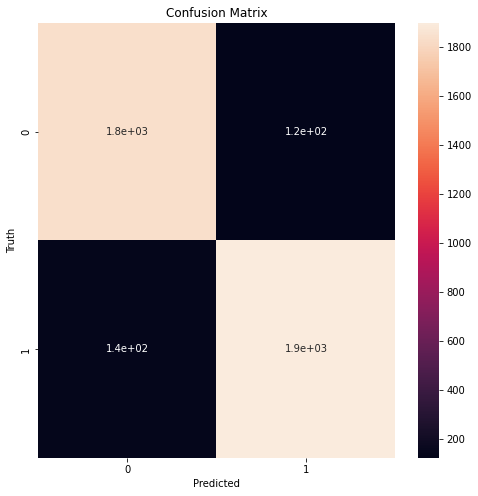

In [ ]:
plt.figure(figsize=(8,8))
cm = confusion_matrix(Y_test,Y_predicted_data)
sns.heatmap(cm,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.title("Confusion Matrix")
plt.show()

1/1 [==============================] - 0s 64ms/step


/usr/local/lib/python3.7/dist-packages/keras/utils/image_utils.py:382: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


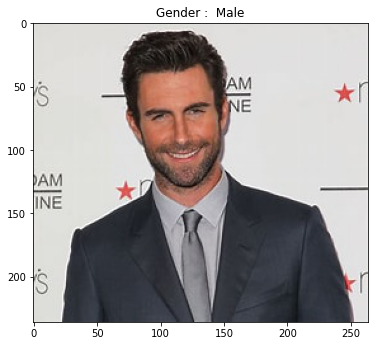

In [ ]:
# Predicting a single image to this model

img = keras.preprocessing.image.load_img('/content/img_male2.jpg',grayscale=True)
img_resize = img.resize((128,128) , PIL.Image.ANTIALIAS)
img_resize = np.array(img_resize)
img = img_resize.reshape(1,128,128,1)

res =model.predict(img)

if int(res[0][0])==1:
  output = "Female"
else:
  output = "Male"

plt.figure(figsize=(6,6))
img_arr = keras.preprocessing.image.load_img('/content/img_male2.jpg')
plt.imshow(img_arr)
plt.title(f"Gender :  {output}")
plt.show()

# Save the Model

In [ ]:
model.save('gender_prediction_model.h5')